# Demo - RBIG

In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config

# import chex
config.update("jax_enable_x64", True)

import chex
import numpy as np
from functools import partial

# library functions
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss

KEY = jax.random.PRNGKey(123)

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import corner
from IPython.display import HTML

%matplotlib inline

sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)

%load_ext lab_black

%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Demo Data

In [82]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# %%wandb
# get data
seed = 123
n_samples = 5_000
n_features = 2
noise = 0.05

X, y = datasets.make_s_curve(n_samples=n_samples, noise=noise, random_state=seed)

data = X[:, [0, 2]]

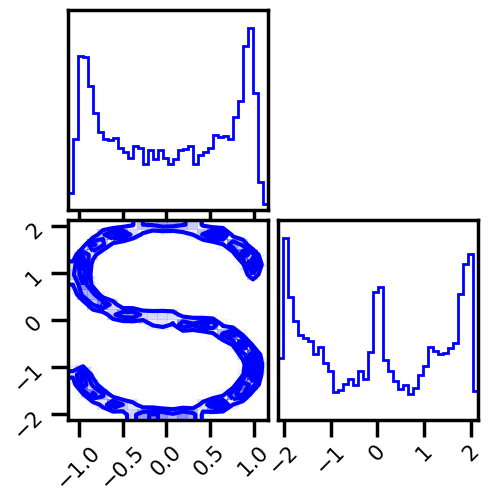

In [83]:
# plot data
fig = corner.corner(data, color="blue", hist_bin_factor=2)
plt.show()

In [84]:
X = jnp.array(data, dtype=np.float64)

## Model

In [85]:
from rbig_jax.models import RBIG

# a lot of parameters...
support_extension = 30
precision = 1_000
eps = 1e-5
method = "kde"
# Histogram specific params
nbins = None
alpha = 1e-5
# KDE specific params
bw = "scott"

# info reduction loss parameters
max_layers = 1_000
zero_tolerance = 20
p = 0.10

# initialize the max layers parameters
verbose = True
n_layers_remove = 0
interval = 10

# everything (makes it fast...)
jitted = True

#### Training

In [86]:
X_g, rbig_model = RBIG(
    X=X,
    support_extension=support_extension,
    method=method,
    precision=precision,
    alpha=alpha,
    nbins=nbins,
    bw=bw,
    eps=eps,
    max_layers=max_layers,
    zero_tolerance=zero_tolerance,
    p=p,
    verbose=verbose,
    n_layers_remove=n_layers_remove,
    interval=interval,
    jitted=jitted,
)

Layer 10 - Cum. Info Reduction: 1.807 - Elapsed Time: 5.2409 secs
Layer 20 - Cum. Info Reduction: 2.017 - Elapsed Time: 8.0786 secs
Layer 30 - Cum. Info Reduction: 2.106 - Elapsed Time: 10.8000 secs
Layer 40 - Cum. Info Reduction: 2.143 - Elapsed Time: 13.5868 secs
Layer 50 - Cum. Info Reduction: 2.143 - Elapsed Time: 16.3909 secs
Layer 60 - Cum. Info Reduction: 2.162 - Elapsed Time: 19.3499 secs
Layer 70 - Cum. Info Reduction: 2.181 - Elapsed Time: 22.2976 secs
Layer 80 - Cum. Info Reduction: 2.181 - Elapsed Time: 25.1554 secs
Layer 90 - Cum. Info Reduction: 2.214 - Elapsed Time: 28.0903 secs
Layer 100 - Cum. Info Reduction: 2.255 - Elapsed Time: 31.9224 secs
Layer 110 - Cum. Info Reduction: 2.255 - Elapsed Time: 35.5157 secs
Converged at Layer: 117
117 3 0
Final Number of layers: 117 (Blocks: 39)
Total Time: 37.7045 secs


### Gaussianized Data

#### Training Loop

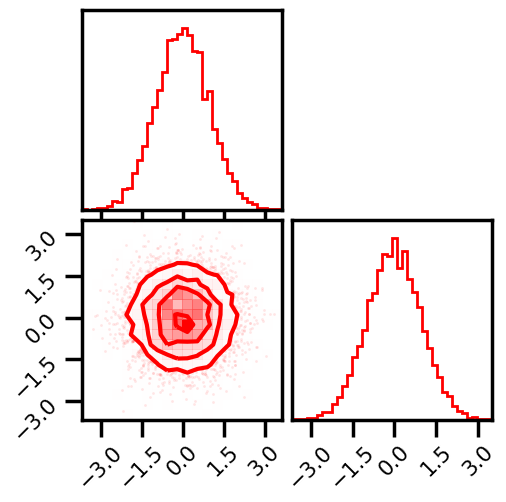

In [87]:
# plot data
fig = corner.corner(np.array(X_g), color="red", hist_bin_factor=2)
plt.show()

#### From Model

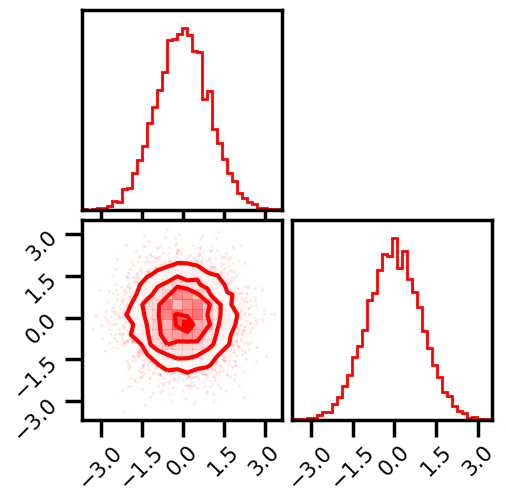

CPU times: user 12.3 s, sys: 1.04 s, total: 13.3 s
Wall time: 11.3 s


In [88]:
%%time
X_g_ = rbig_model.forward(X)

# plot data
fig = corner.corner(np.array(X_g_), color="red", hist_bin_factor=2)
plt.show()

#### Information Reduction Evolution

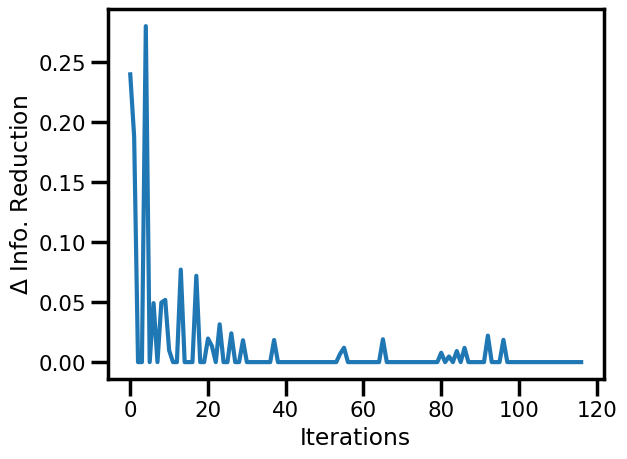

In [89]:
fig, ax = plt.subplots()
ax.plot(rbig_model.info_loss)
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

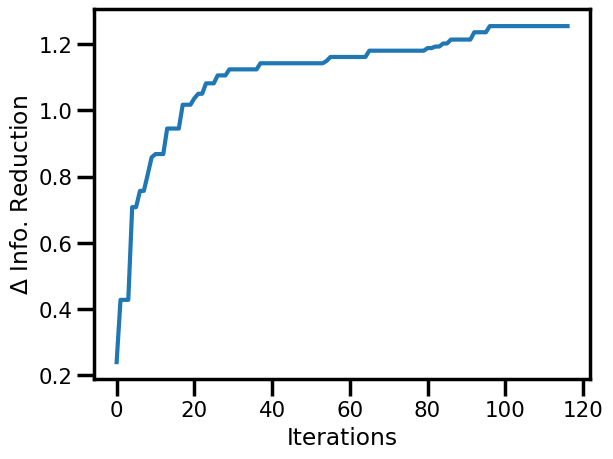

In [90]:
fig, ax = plt.subplots()
ax.plot(jnp.cumsum(rbig_model.info_loss))
ax.set(xlabel="Iterations", ylabel="$\Delta$ Info. Reduction")
plt.show()

#### Negative Log-Likelihood

In [91]:
%%time

X_valid, y = datasets.make_moons(n_samples=1_000, noise=noise, random_state=42)

nll = rbig_model.score(X_valid)
print(f"NLL Score: {nll:.4f}")

NLL Score: 43.3507
CPU times: user 18 s, sys: 1.62 s, total: 19.6 s
Wall time: 17.1 s


### Density Estimation

In [92]:
# Original Density
n_samples = 1_000_000
noise = 0.05
seed = 42
X_plot, _ = datasets.make_moons(n_samples=n_samples, noise=noise, random_state=seed)

In [93]:
%%time

n_grid = 200
buffer = 0.01
xline = jnp.linspace(X[:, 0].min() - buffer, X[:, 0].max() + buffer, n_grid)
yline = jnp.linspace(X[:, 1].min() - buffer, X[:, 1].max() + buffer, n_grid)
xgrid, ygrid = jnp.meshgrid(xline, yline)
xyinput = jnp.concatenate([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], axis=1)


X_log_prob = rbig_model.score_samples(xyinput)

CPU times: user 29.3 s, sys: 2.09 s, total: 31.4 s
Wall time: 18.1 s


#### Generate Grid Points

#### Plot - Compare

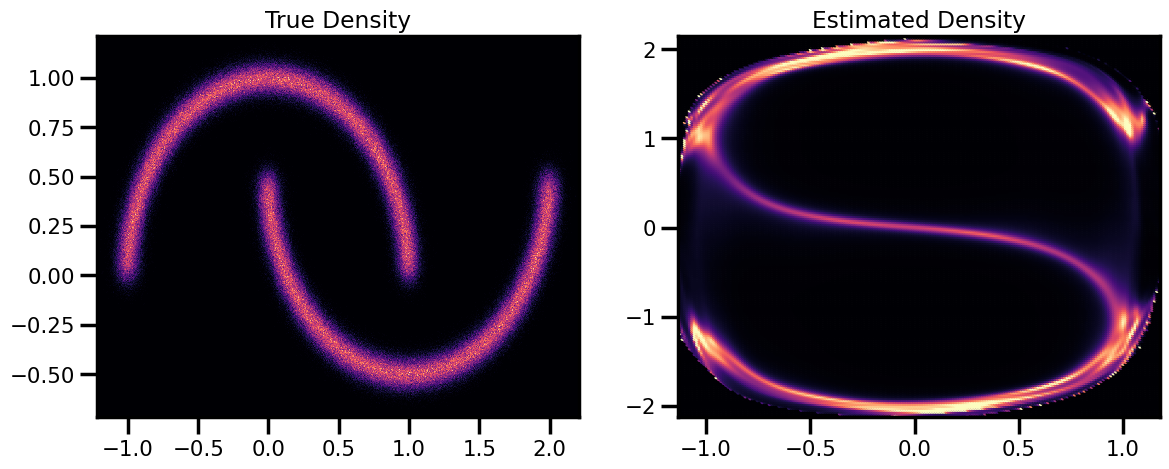

In [94]:
# Estimated Density
cmap = cm.magma  # "Reds"
probs = jnp.exp(X_log_prob)


fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True,  # vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)

h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
# plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()

### Sampling

In [95]:
%%time

# number of samples
n_samples = 10_000
seed = 42

X_samples = rbig_model.sample(seed=seed, n_samples=n_samples)

CPU times: user 9.39 s, sys: 823 ms, total: 10.2 s
Wall time: 8.3 s


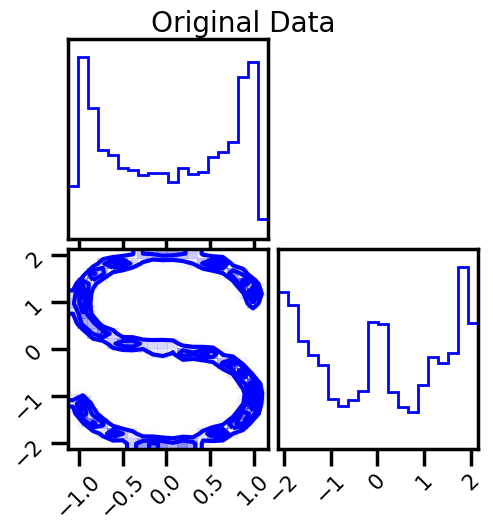

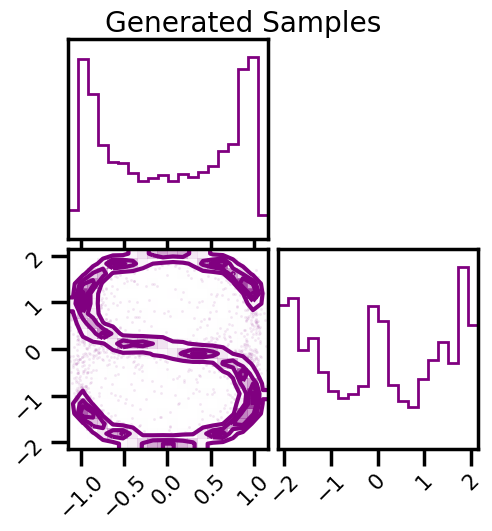

In [96]:
fig = corner.corner(np.array(X), color="blue", label="Original Data")
fig.suptitle("Original Data")
plt.show()

fig2 = corner.corner(np.array(X_samples), color="purple")
fig2.suptitle("Generated Samples")
plt.show()

## Saving and Loading

Often times it would be nice to save and load models. This is useful for checkpointing (during training) and also for convenience if you're doing research on google colab.

Fortunately, everything here are python objects, so we can easily save and load our models via `pickle`.

#### Saving

Do to the internals of python (and design choices within this library), one can only store `objects`. So that includes the `rbig_block`, the `bijectors` and also the `rbig_model`. This does not include the `rbig_block_init` for example because that isn't an object, it's a function with some local params.

In [20]:
import joblib

joblib.dump(rbig_model, "rbig_model_plane.pickle")

['rbig_model_plane.pickle']

#### Loading

Loading is straight forward!

In [21]:
rbig_model_loaded = joblib.load("rbig_model_plane.pickle")

#### Simple Test

They won't be the **exact same** byte-for-byte encoding. But they should give the same results either way :).

In [22]:
%%time

# nll for the old model
nll = rbig_model.score(X)

# nll for the loaded model
nll_loaded = rbig_model_loaded.score(X)

# check that they're the same
chex.assert_tree_all_close(nll, nll_loaded)
print(f"NLL (Original): {nll:.4f}")
print(f"NLL (Loaded): {nll_loaded:.4f}")

NLL (Original): 0.6340
NLL (Loaded): 0.6340
CPU times: user 19 s, sys: 1.23 s, total: 20.3 s
Wall time: 19.7 s
